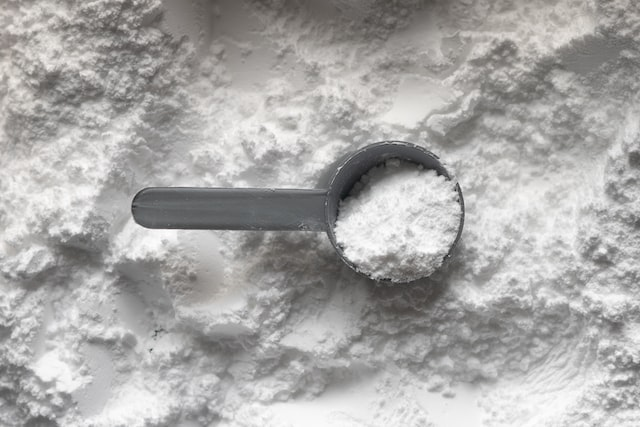

# Introduction

Food product packaging tells us how much protein they contain. It would be easy to think that protein was one just substance. In fact there are numerous different proteins. Each protein is made of some combination of just 20 amino acids. Some proteins have more specialised roles as biological catalysts, or enzymes, and these proteins lie at the heart of this challenge.

In this notebook I am going to look primarily at what can be gleaned from the large training set of enzymes. If we can put together a model which helps us understand their characteristics and predict unknown cases, this may be of value quite apart from its application to the test data, which has very special characteristics.

The main idea behind the competition is that enzymes have specific 3-D structures which enable them to perform their role. At certain temperatures these structures break down or become denatured and this is what we are asked to predict.

# Import data and packages

Import relevant packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import spearmanr

Import data and example submission file.

In [2]:
df_train = pd.read_csv('../input/novozymes-enzyme-stability-prediction/train.csv', index_col = 'seq_id')
df_test = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv', index_col = 'seq_id')
train_updates = pd.read_csv('../input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv')
submission = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv', index_col = 'seq_id')

Drop the data source column for train and test datasets.

In [3]:
df_train.drop(columns = 'data_source', inplace = True)
df_test.drop(columns = 'data_source', inplace = True)

# Data preparation

Each row represents a sequence of amino acids which make up the protein/enzyme. We have two other features in the train data, the pH and the temperature at which the enzyme breaks down - this is our measure of thermostability.

In [4]:
df_train.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


The file with training updates df_updates provides some updated values for the training set. All but 25 of these seem to be null values. The simplest approach is to remove them all.

In [5]:
train_updates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            2434 non-null   int64  
 1   protein_sequence  25 non-null     object 
 2   pH                25 non-null     float64
 3   data_source       0 non-null      float64
 4   tm                25 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 95.2+ KB


In [6]:
for seq_id in train_updates.seq_id:
    df_train = df_train.drop(index = seq_id)

There are 286 records where the pH is not known. Let's leave them in as Xgboost can handle missing values.

In [7]:
print(df_train.isnull().sum())

protein_sequence      0
pH                  286
tm                    0
dtype: int64


Now let's order the dataset in descending thermostability so that the index number provides us with a measure of descending thermostability rank. (We can dispense with the seq_id column).

In [8]:
df_train.sort_values('tm',ascending = False, inplace = True)
df_train.reset_index(inplace = True)
df_train.drop(columns = 'seq_id', inplace = True)

These are the five most thermostable proteins in the dataset.

In [9]:
df_train.head()

,protein_sequence,pH,tm
0,MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...,7.00,130.0
1,MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...,7.00,116.0
2,MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDLPDDWVCPLCGVGK...,9.08,111.8
3,MKKYTCTVCGYIYNPEDGDPDNGINPGTDFKDIPDDWVCPLCGVGK...,9.08,109.5
4,MVEQDPFEIAVKQLERAAQYMDISEEALEFLKRPQRIVEVSIPVEM...,7.00,108.5


# Feature engineering

We need to find some way of converting the strings of amino acids into usable features. Let's start by adding a column to indicate the length of each protein.

In [10]:
list = []
for number in range(len(df_train)):
    list.append(len(df_train.protein_sequence[number]))
df_train['length'] = list

In [11]:
list = []
for number in range(len(df_test)):
    list.append(len(df_test.protein_sequence.iloc[number]))
df_test['length'] = list

Using the list of 20 amino acids, let's create a feature for each one containing their frequency of occurence.

In [12]:
aminos = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
for letter in aminos:
    df_train[letter] = df_train.protein_sequence.str.count(letter)
    df_test[letter] = df_test.protein_sequence.str.count(letter)

The dataset now looks like this.

In [13]:
df_train.head()

,protein_sequence,pH,tm,length,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...,7.00,130.0,98,15,2,5,2,3,10,...,3,2,4,5,1,3,2,9,2,2
1,MKKFLLVAVVGLAGITFANEQLAKQKGCMACHDLKAKKVGPAFADV...,7.00,116.0,98,15,2,5,2,3,10,...,3,2,4,5,1,3,2,9,2,2
2,MKKYTCTVCGYIYNPEDGDPDNGVNPGTDFKDLPDDWVCPLCGVGK...,9.08,111.8,54,0,4,8,5,2,6,...,1,3,5,1,0,0,3,5,1,3
3,MKKYTCTVCGYIYNPEDGDPDNGINPGTDFKDIPDDWVCPLCGVGK...,9.08,109.5,54,0,4,8,5,2,6,...,1,3,5,1,0,0,3,4,1,3
4,MVEQDPFEIAVKQLERAAQYMDISEEALEFLKRPQRIVEVSIPVEM...,7.00,108.5,419,41,2,25,33,9,33,...,17,16,20,9,19,17,26,36,10,20


Rather than train on all the data, let's use a proportion with an existing level of reasonable thermostability - say 55 degrees. This still gives us nearly 7,000 proteins for our model.

In [14]:
df_train = df_train[df_train.tm>55]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6909 entries, 0 to 6908
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  6909 non-null   object 
 1   pH                6840 non-null   float64
 2   tm                6909 non-null   float64
 3   length            6909 non-null   int64  
 4   A                 6909 non-null   int64  
 5   C                 6909 non-null   int64  
 6   D                 6909 non-null   int64  
 7   E                 6909 non-null   int64  
 8   F                 6909 non-null   int64  
 9   G                 6909 non-null   int64  
 10  H                 6909 non-null   int64  
 11  I                 6909 non-null   int64  
 12  K                 6909 non-null   int64  
 13  L                 6909 non-null   int64  
 14  M                 6909 non-null   int64  
 15  N                 6909 non-null   int64  
 16  P                 6909 non-null   int64  


# Fitting the model

In [15]:
X = df_train.drop(columns = ['tm','protein_sequence'])
y = df_train['tm']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 11)

In [17]:
# parameters tuned separately
model1 = xgb.XGBRegressor(n_estimators = 170, max_depth = 5)
model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)

In [18]:
print('Mean Absolute Error =', mean_absolute_error(y_test, predictions1))
print('Mean Absolute Percentage Error = ', mean_absolute_percentage_error(y_test, predictions1))

Mean Absolute Error = 5.0575107706955995
Mean Absolute Percentage Error =  0.07177800248942544


The Spearman Correlation Coefficient is the main metric for this competition.

In [19]:
rho, p = spearmanr(y_test, predictions1)
print('Spearman Correlation Coefficient =', rho.round(3))


Spearman Correlation Coefficient = 0.787


# Feature importances

In [20]:
feature_imp = pd.Series(model1.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

C         0.189253
N         0.137145
R         0.110480
Q         0.077510
S         0.073452
A         0.042871
Y         0.033863
I         0.033615
pH        0.030501
G         0.030392
V         0.028024
L         0.027101
E         0.024982
P         0.024911
M         0.020285
K         0.020271
T         0.018633
W         0.018467
D         0.017751
F         0.014644
H         0.013852
length    0.011997
dtype: float32

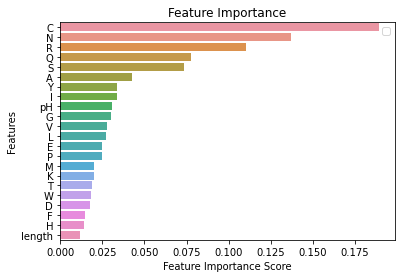

In [21]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()

# The test data

The main features in our model are the individual amino acids. The test set consists of just one protein with lots of small mutations, so there is very little variation in the numbers of individual amino acids.

In [22]:
df_test

,protein_sequence,pH,length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
seq_id,,,,,,,,,,,,,,,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,22,4,15,8,10,19,0,...,0,19,17,13,3,18,8,13,6,6
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,22,4,15,7,10,19,0,...,0,19,17,13,3,18,8,13,6,6
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,220,22,4,15,7,10,19,0,...,0,19,17,13,3,18,8,13,6,6
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,22,5,15,7,10,19,0,...,0,19,17,13,3,18,8,13,6,6
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,22,4,15,7,11,19,0,...,0,19,17,13,3,18,8,13,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,21,4,15,7,10,19,0,...,0,19,17,13,3,18,8,13,6,6
33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,21,4,15,7,10,19,0,...,0,19,17,13,3,18,8,13,6,6
33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,221,21,4,15,7,10,19,0,...,0,20,17,13,3,18,8,13,6,6


There are only 2 lengths to the amino acid chain.

In [23]:
df_test.length.value_counts()

221    2336
220      77
Name: length, dtype: int64

The pH feature is of no help since every value in the test set is 8.

In [24]:
df_test.pH.value_counts()

8    2413
Name: pH, dtype: int64

Our model does not perform particularly well on predicting the thermostability of the test data set for these reasons. Neverthless an earlier version came midway in the leaderboard so not terrible.

# Conclusion

Our model is a relatively simple one, which still has some value as a quick and straightforward predictor of enzyme thermostability.